

第1步：数据准备与知识库构建
核心技术

多格式解析

技术细节：处理PDF、HTML、Word、Markdown等格式，需提取结构化文本并保留标题、列表等逻辑结构。
工具推荐：

PyPDF2 / PDFMiner：提取PDF文本，解决扫描版PDF需配合OCR（如Tesseract）。
BeautifulSoup / Readability：清理网页HTML标签，提取正文。
Apache Tika：统一解析多种格式（包括Office文档）。




文本清洗

技术细节：去除广告、导航栏、特殊字符，标准化编码（如UTF-8），处理缩写和拼写错误。
正则表达式：匹配删除无关内容（如“点击查看详情”）。
NLP工具：Spacy的规则引擎识别保留关键实体（如产品型号、技术术语）。


元数据管理

技术细节：为文本块附加来源、创建时间、作者等信息，用于后续检索排序。
实现方案：在JSON或数据库中存储{text: "...", source: "手册_v3.pdf", page: 12}。



典型代码结构
from bs4 import BeautifulSoup
import pdfplumber

# 解析PDF
with pdfplumber.open("manual.pdf") as pdf:
    text = "\n".join([page.extract_text() for page in pdf.pages])

# 清洗网页
html = requests.get(url).text
soup = BeautifulSoup(html, "lxml")
main_text = soup.find("div", class_="main-content").get_text(strip=True)


第2步：文本切分（Chunking）
分块策略

固定窗口法：

技术细节：每块固定长度（如512 tokens），重叠窗口（overlap=10%）避免语义断裂。
代码示例：from langchain.text_splitter import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size=512, chunk_overlap=64, separators=["\n\n", "\n", "。", " "]
)
chunks = splitter.split_text(text)




语义分块法：

技术细节：用NLP模型检测段落边界（如Spacy的句子分割），适合技术文档。
工具：Spacy的sentencizer组件或基于Transformer的语义分割模型。



优化技巧

动态分块：根据内容类型调整块大小（如论文摘要用256 tokens，实验细节用1024 tokens）。
分块元数据：标记块类型（标题、代码示例、表格）供检索时加权。


第3步：向量化与嵌入（Embedding）
嵌入模型选型

闭源API：

OpenAI text-embedding-3-small：1536维，适合通用场景，成本约$0.0001/1k tokens。
Cohere Embed：支持多语言，提供压缩模式（降低维度节省存储）。


开源模型：

Sentence-BERT（sentence-transformers库）：预训练模型如all-mpnet-base-v2，微调支持领域适配。
BGE（BAAI General Embedding）：中文优化，支持指令微调（在提示词前加“为这个句子生成嵌入：”）。



批量计算与加速

GPU加速：用PyTorch的DataLoader多线程批量处理。
降维：PCA或UMAP将向量从1536维降至256维，减少存储和计算量。

代码示例
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(chunks, batch_size=128, show_progress_bar=True)


第4步：向量存储与检索
数据库选型对比



数据库
适用场景
关键特性




FAISS
中小规模（百万级），本地部署
GPU加速、IVF索引、支持L2/IP相似度


Pinecone
大规模，全托管云服务
自动缩放、混合搜索（稀疏+稠密向量）


Milvus
自托管，分布式扩展
支持标量过滤、数据分片、高可用


Elasticsearch
已有ES生态集成
8.0+支持kNN搜索，可与全文检索结合



索引结构优化

HNSW（Hierarchical Navigable Small World）：

参数：efConstruction=200（构建时邻居数）、efSearch=100（搜索时扩展数），权衡精度与速度。


IVF（Inverted File Index）：

聚类为nlist=4096个分区，搜索时仅查最近簇，适合超大规模数据集。



检索逻辑
import faiss
index = faiss.IndexHNSWFlat(embedding_dim, 32)
index.add(embeddings)
distances, indices = index.search(query_embedding, k=5)


第5步：检索增强生成（RAG）
提示词工程

模板设计：基于以下上下文，精确回答问题。如果答案不在上下文中，回答“未知”。

上下文：
{context_str}

问题：{query_str}


多步推理：对复杂问题先检索多个相关块，分步生成中间结论（Chain-of-Thought）。

生成模型优化

模型选择：

GPT-4：高成本，适合对准确性要求严苛的场景（如医疗、法律）。
Llama 3 70B：开源替代，需16GB以上GPU显存，使用vLLM库加速推理。


生成参数：

temperature=0.3（降低随机性），max_tokens=500，stop_sequences=["\n参考："]。



代码流程
from langchain.chains import RetrievalQA
qa_chain = RetrievalQA.from_chain_type(
    llm=llm, 
    retriever=vector_db.as_retriever(),
    chain_type="stuff"  # 或"map_reduce"处理长文本
)
answer = qa_chain.run("如何拆卸联想Y7000的电池？")


第6步：评估与优化
评估指标

检索阶段：

命中率（Hit Rate）：Top-K结果中包含正确答案的比例。
MRR（Mean Reciprocal Rank）：正确答案排名的倒数均值。


生成阶段：

ROUGE-L：衡量生成文本与标准答案的词汇重叠率。
BERTScore：用BERT模型评估语义相似度。



优化手段

重排序（Rerank）：

用交叉编码器（Cross-Encoder）对Top-100检索结果重新评分。
代码示例（使用Sentence-Transformers）：from sentence_transformers import CrossEncoder
model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
scores = model.predict([(query, chunk) for chunk in chunks])




混合检索：结合关键词（BM25）与语义搜索，提升召回率。


扩展：高级RAG架构

多跳检索（Multi-Hop）

场景：复杂问题需多次检索（如“Y7000的电池型号是什么？该型号的供应商有哪些？”）。
实现：用LLM生成中间问题→分步检索→综合答案。


动态数据更新

技术：监听知识库文件夹变动（如Watchdog库）→触发增量嵌入更新。




技术栈全景图
用户提问 → 解析清洗 → 分块 → 向量化 → 存储 → 检索 → 增强生成 → 评估  
                │          │           │         │           │  
                ↓          ↓           ↓         ↓           ↓  
         Apache Tika   LangChain   Sentence-BERT  FAISS    GPT-4/Llama



In [ ]:
# pip install langchain sentence-transformers faiss-cpu openai tiktoken python-dotenv

import os
from dotenv import load_dotenv
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# 加载环境变量（用于OpenAI API）
load_dotenv() 

# ========================= 第1步：知识库准备 =========================
# 创建示例知识库文件（实际场景替换为你的文档）
with open("knowledge_base.md", "w", encoding="utf-8") as f:
    f.write("""
## 联想笔记本电池更换指南
1. 关机并断开所有外接电源。
2. 使用T5螺丝刀卸下底部螺丝（共8颗）。
3. 从边缘撬开底盖，注意不要损坏卡扣。
4. 找到电池连接器，轻轻拔出。
5. 更换新电池后按相反顺序组装。

## 天禧AI隐私保护功能
- 本地数据处理：用户对话内容优先在设备端处理。
- 差分隐私技术：上传数据时添加噪声保护个体信息。
- 权限控制：可随时在设置中关闭数据收集。
    """)

# ========================= 第2步：文档加载与分块 =========================
loader = TextLoader("knowledge_base.md", encoding="utf-8")
documents = loader.load()

# 智能分块（每块512字符，重叠64字符）
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=64,
    separators=["\n\n", "\n", "。", " "]
)
chunks = text_splitter.split_documents(documents)

# ========================= 第3步：向量嵌入与存储 =========================
# 使用Sentence-BERT生成嵌入
embed_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

# 创建FAISS向量库
vector_db = FAISS.from_documents(
    chunks, 
    embed_model
)
vector_db.save_local("faiss_index")  # 保存索引供后续使用

# ========================= 第4步：检索增强生成 =========================
def rag_answer(question: str) -> str:
    # 加载预存的向量库
    vector_db = FAISS.load_local(
        "faiss_index", 
        embed_model,
        allow_dangerous_deserialization=True  # FAISS需要此参数
    )
    
    # 检索最相关的3个块
    retrieved_docs = vector_db.similarity_search(question, k=3)
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])
    
    # 构建提示词模板
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", "基于以下上下文，用简洁的技术语言回答问题。如果无法回答，请说明未知内容。\n\n上下文：{context}"),
        ("human", "问题：{question}")
    ])
    
    # 调用生成模型（此处用OpenAI，生产环境可替换为Llama等）
    llm = ChatOpenAI(
        model="gpt-3.5-turbo",
        temperature=0.3
    )
    chain = prompt_template | llm
    
    # 执行生成
    response = chain.invoke({"question": question, "context": context})
    return response.content

# ========================= 测试 =========================
if __name__ == "__main__":
    while True:
        question = input("\n请输入问题（输入q退出）: ")
        if question.lower() == "q":
            break
        print("\n回答：", rag_answer(question))


https://blog.csdn.net/weixin_42475060/article/details/145886142
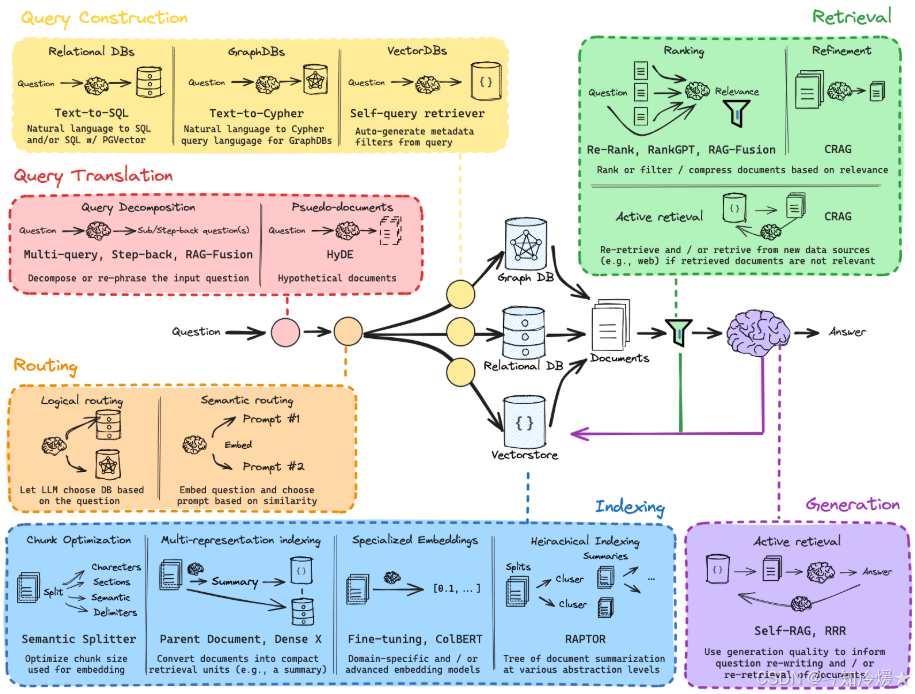


Query Construction（查询构建）

从不同类型数据库构建查询

Relational DBs（关系型数据库）

在处理关系型数据库时，可能会使用Text-to-SQL技术。它将自然语言问题转换为SQL查询语句，以便从关系型数据库中检索相关数据。例如，对于问题“查找销售额最高的前5名产品”，Text-to-SQL模块会生成类似“SELECT product_name, sales_amount FROM products ORDER BY sales_amount DESC LIMIT 5”的SQL语句。


GraphDBs（图数据库）

针对图数据库，如Neo4j等，会采用Text-to-Cypher的方式。例如，对于“找出与节点A直接相连的所有节点”这样的自然语言问题，Text-to-Cypher会生成相应的Cypher查询语句“MATCH (a:Node {name: 'A'}) -[r]-> (b:Node) RETURN b”。


VectorDBs（向量数据库）

对于向量数据库，可能利用Self - Natural Language to Query Generator for Graphs等技术。当需要查找与某个特定向量表示相似的向量数据时（例如在基于向量的语义搜索中），会生成相应的查询来从向量数据库中检索相似向量所对应的文档或数据。




作用和重要性

这一步骤是整个RAG流程的起始点，准确地将自然语言问题转化为数据库可理解的查询语句，决定了能否从相应数据源中获取到正确且相关的数据，为后续的处理提供基础。



Query Translation（查询翻译）

多种翻译策略

Equivalent question translation（等价问题翻译）

其目的是通过将原始自然语言问题转换为等价的其他表述形式，扩大检索的范围和可能性。例如，将“哪些电影是由斯皮尔伯格导演的”等价翻译为“斯皮尔伯格执导的电影有哪些”等不同表述，以提高检索到相关数据的概率。


Multi - query, RAG - Fusion, Decomposition, Step - back, HYDE等技术

Multi - query（多查询）：会生成多个不同版本的查询，这些查询可能在语义、语法或侧重点上有所不同，以覆盖更多可能的检索角度。
RAG - Fusion（RAG融合）：可能涉及将多个相关查询或检索结果进行融合，以综合更多信息。
Decomposition（分解）：把复杂的问题分解为多个较简单的子问题，分别进行检索和处理，最后再整合结果。例如对于“找出过去5年中每个季度销售额最高的产品以及其对应的销售区域”，可分解为先查询每个季度销售额最高的产品，再查询这些产品对应的销售区域等子问题。
Step - back（回退）：在某些检索策略不成功时，回退到更通用或更基础的查询方式重新尝试检索。
HYDE（假设文档嵌入）：通过假设文档的嵌入来辅助查询的转换和优化，可能通过预先生成一些假设文档的向量表示，与查询向量进行比较和调整，使查询更符合实际数据的分布和特征。
考虑到其他的方法都是通过计算query和doc的相似度来检索文档的，但实际上，query和doc有很多不同之处。HyDE (Hypothetical Document Embeddings)根据用户输入的query生成一些假设的doc，将这些doc转换为向量形式，利用这些向量从一个索引(database/index)中检索相关的doc。
例子
用户提问:“What are the health benefits of green tea?”(绿茶的健康益处是什么?)
HyDE 方法就会生成一个或多个假设文档，例如:
一篇关于绿茶中含有的抗氧化剂及其对健康好处的文档。
一篇讨论绿茶对心血管健康的影响的文档。




作用和重要性

通过这些策略，将原始问题转换为更适合检索的形式，提高从外部数据源获取到准确且全面相关数据的可能性，避免因单一查询形式的局限性而遗漏重要信息。



Routing（路由）

基于不同规则的路由选择
举例:
假设我们有多个索引:
1.一个索引包含了所有与LangChain相关的Python文档.
2.另一个索引包含了所有与LangChain相关的JavaScript文档,
用户query:“如何在LangChain中使用Python进行文本分析?
    选择包含所有LangChain Python文档的索引进行查询。
用户query:“LangChain的JS库是否支持WebSocket?“
    选择包含LangChain JavaScript文档的索引进行查询。

Logical Routing（逻辑路由）

根据预先设定的逻辑规则来选择合适的数据库进行查询。例如，如果问题涉及到结构化的表格数据且需要复杂的关系查询，逻辑路由可能会选择关系型数据库；如果涉及到知识图谱类型的数据和关系查询，则会选择图数据库等。


Semantic Routing（语义路由）

通过计算问题与不同数据库中数据的语义相似度来决定路由。图中的Prompt #1和Prompt #2可能是用于辅助语义路由决策的提示模板或辅助信息。例如，对于一个关于电影知识的问题，通过比较问题与电影相关数据库（如包含电影信息的图数据库或向量数据库）的语义相似度，来决定将查询路由到该数据库进行检索。




作用和重要性

路由机制确保查询能够被发送到最合适的数据源进行处理，提高检索效率和准确性，避免在不相关或不合适的数据源上浪费资源和时间。



Indexing（索引）

不同的索引方式

Parent Document, Dense X

对父文档进行索引，其中Dense X可能涉及使用密集向量表示来对文档进行索引。例如，对于一篇较长的文档，将其转换为密集向量表示后存储在索引中，以便后续通过向量相似度搜索快速找到相关文档。


Domain - specific and/or various abstraction levels（特定领域和不同抽象层次）

根据不同的特定领域特点构建索引。例如在医学领域，会根据医学术语、疾病分类等特定领域知识构建索引；同时，还会在不同的抽象层次上构建索引，比如对于一篇医学研究论文，既会在论文整体层面构建索引，也会在章节、段落甚至句子等不同层次构建索引，以满足不同粒度的检索需求。




作用和重要性

有效的索引构建可以大大提高检索速度和准确性，通过合适的索引方式，能够快速定位到与查询相关的文档或数据，尤其是在大规模数据集中，索引的作用尤为重要。

RAPTOR
问题:"低层次"的query，指那些只需要单一文档就可以回答的query;"高层次”的问题，指那些需要多个文档结合才会回答的query。此时，典型的kNN检索可能并不适用，因为kNN检索只能检索有限数量的文档块。
想法:通过创建捕捉更高层次概念的文档摘要来解决这个问题。嵌入并聚类文档，然后总结每个聚类。以递归的方式这样做，产生一个包含越来越高层次概念的摘要树。摘要和起始文档一起被索引，覆盖用户query的范围。
DPR（Dense Passage Retrieval）
基本原理
基于向量表示的检索
DPR主要基于密集向量表示来进行段落检索。它会为每个段落以及查询都生成一个密集向量表示。对于段落，通过预训练的模型将其编码为固定维度的向量；对于查询（即用户提出的问题等）也进行同样的编码处理。
然后通过计算查询向量与各个段落向量之间的相似度（通常采用点积或余弦相似度等度量方式）来找到与查询最相关的段落。
双编码器架构
一般采用双编码器架构，一个编码器用于对查询进行编码，另一个用于对段落进行编码。这种架构允许分别对查询和段落进行独立的编码处理，并且在检索时可以快速计算大量段落与查询的相似度，提高检索效率。
应用场景和优势
信息检索任务
在问答系统、文档检索等信息检索相关的任务中广泛应用。例如在一个基于知识库的问答系统中，DPR可以快速从大量的文档或段落中检索出与用户问题最相关的部分，为后续的答案生成提供准确的信息来源。
高效准确
其优势在于能够快速准确地检索到相关段落，尤其是在处理大规模文本数据时，通过向量空间的高效搜索，避免了传统基于关键词匹配检索方法的一些局限性（如语义理解不足、对同义词等处理能力有限等），能够更好地捕捉到语义层面的相关性。
ColBERT（Contextualized Late Interaction over BERT）
基本原理
基于BERT的上下文交互
ColBERT建立在BERT模型的基础上，利用BERT对文本的强大上下文理解能力。它在处理查询和文档（或段落）时，会分别对它们进行编码，但与DPR不同的是，它不仅仅是简单地计算整体向量的相似度。
在计算相似度时，它会考虑查询中每个词与文档中每个词的细粒度交互，即所谓的“late interaction”。具体来说，它会将查询和文档的词向量表示进行逐词的相似度计算，并综合这些细粒度的相似度结果来衡量整体的相关性。
上下文感知的相关性计算
这种方式使得它能够更好地利用文本中的上下文信息来判断相关性。例如，对于一个具有多种含义的词，它可以根据其在具体上下文中的含义来更准确地与查询进行匹配和相关性评估，而不是像一些简单的基于词向量平均或整体向量的方法那样可能会忽略上下文导致不准确的判断。
应用场景和优势
需要高精度语义匹配的场景
在一些对检索精度要求较高、需要更深入语义理解和匹配的场景中表现出色，如专业领域的知识检索、法律文档检索等。在这些场景中，细微的语义差异可能会对检索结果的准确性产生重大影响，而ColBERT的上下文感知能力有助于提高这种精度。
语义理解优势
优势在于其对语义的精细处理和利用上下文信息进行相关性判断的能力，相比一些传统的检索方法和相对较粗粒度的向量检索方法，它能够提供更符合人类语义理解的检索结果，从而提高信息检索系统的整体性能和用户体验。

Retrieval（检索）

主动检索及相关技术

Active Retrieval（主动检索）

主动从选定的数据库中检索相关文档。例如在向量数据库中，通过计算查询向量与数据库中存储的文档向量的相似度，主动获取相似度较高的文档；在关系型数据库中，通过执行构建好的查询语句获取相关数据记录等。并且在检索过程中可能涉及重新查询或重新检索文档等操作，以不断优化检索结果。


RAG - Fusion、Re - rank、RankGPT、RAG - Fusion、CRAG等技术

RAG - Fusion（RAG融合）：对从不同数据源或通过不同检索方式获取到的结果进行融合，综合多方面的信息。
Re - rank（重新排序）：对初步检索到的文档或数据根据一定的标准（如相关性得分、置信度等）进行重新排序，将最相关的结果排在前面。例如使用RankGPT等技术，通过语言模型对检索结果进行评估和重新排序。
CRAG（可能是某种特定的检索或融合技术）：可能涉及对检索到的文档进行进一步的筛选、压缩或整合等操作，以得到更精炼且相关的结果。




作用和重要性

通过这些检索技术，从数据源中获取到最相关的文档或数据，为后续的生成阶段提供准确且有用的信息基础，直接影响最终生成答案的质量。



Generation（生成）

基于检索结果的生成及相关操作

Use generation quality to inform re - ranking or re - retrieval of documents（利用生成质量来指导重新排序或重新检索文档）

根据当前生成的答案质量来决定是否需要重新对检索到的文档进行排序或重新进行检索。例如，如果生成的答案质量较低（如不完整、不准确等），可能会触发重新对检索到的文档进行评估和重新排序，或者重新从数据源中检索更多可能相关的文档。


Self - Hierarchical RAG、RRR、RAPTOR等技术

Self - Hierarchical RAG（自分层RAG）：可能涉及在生成答案时，根据问题的层次结构和检索到的文档的层次关系，分层级地生成答案，从整体到局部逐步完善答案内容。
RRR（可能是某种特定的生成或优化技术）：通过特定的规则或算法对生成的答案进行优化或调整。
RAPTOR（可能是某种特定的生成技术或模型）：利用特定的模型或技术基于检索到的相关文档生成最终的回答，可能涉及对文档内容的整合、推理等操作。




作用和重要性

这一阶段是整个RAG流程的最终输出环节，通过合理利用检索到的信息和各种生成技术，生成准确、完整且符合用户需求的答案，是整个方法实现其价值的关键步骤。



Optimization（优化）

不同的优化操作

Chunk Optimizer（块优化器）

对数据块进行优化，主要涉及调整数据块的大小等操作。例如，在处理文档数据时，根据文档的内容特点和检索需求，动态调整将文档分割成的数据块大小，以提高检索效率和准确性。如果数据块过大，可能会包含过多不相关信息影响检索；如果过小，又可能破坏文档的语义完整性，所以需要进行优化。


Semantic Splitter（语义分割器）

根据语义对文档进行分割。它不是简单地按固定长度或格式分割文档，而是基于语义理解将文档划分为更有意义的部分。例如，对于一篇包含多个主题段落的文章，语义分割器可以将其按主题段落进行分割，使得每个分割后的部分都具有相对独立且完整的语义，方便后续的索引、检索和生成等操作。




作用和重要性

优化操作可以提高整个RAG系统的性能和效率，通过合理的块优化和语义分割，使得数据的处理更加高效和准确，有助于提高检索和生成的质量。



